In [1]:
import sys
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline


## imports

In [3]:
from pydantic import BaseModel, RootModel
from devtools import pprint
import os

In [4]:
from ocrorchestrator.config.app_config import AppConfig

In [5]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../../../secrets/calm-producer-428509-t9-b428a168489d.json"

## testing config

In [6]:
config_data = {
        "general": {
            # General config fields
        },
        "categories": {
            "proof_of_funds": {
                "validation": {
                    "processor": "llm",
                    "handler": "gemini-pro-vision"
                },
                "extraction": {
                    "processor": "custom",
                    "handler": "ProofOfFundsExtractor"
                }
            },
            "checks": {
                "extraction": {
                    "processor": "custom",
                    "handler": "ProofOfFundsExtractor"
                }
            }
        }
    }

In [7]:
mm = AppConfig(**config_data)

In [8]:
mm.categories["proof_of_funds"]

OrderedDict([('validation',
              TaskConfig(processor='llm', api=None, model=None, prompt_template=None, params=[], fields=None, classes=None, args=[], kwargs={})),
             ('extraction',
              TaskConfig(processor='custom', api=None, model=None, prompt_template=None, params=[], fields=None, classes=None, args=[], kwargs={}))])

In [9]:
for cat, tsk, cfg in mm.iterate():
    print(cat, tsk, cfg)

proof_of_funds validation processor='llm' api=None model=None prompt_template=None params=[] fields=None classes=None args=[] kwargs={}
proof_of_funds extraction processor='custom' api=None model=None prompt_template=None params=[] fields=None classes=None args=[] kwargs={}
checks extraction processor='custom' api=None model=None prompt_template=None params=[] fields=None classes=None args=[] kwargs={}


In [10]:
pprint(mm.get_task_config("proof_of_funds", "validation"))

TaskConfig(
    processor='llm',
    api=None,
    model=None,
    prompt_template=None,
    params=[],
    fields=None,
    classes=None,
    args=[],
    kwargs={},
)


## testing repos

In [11]:
from ocrorchestrator.repos.factory import RepoFactory
from ocrorchestrator.managers.secrets import setup_google_credentials

In [12]:
setup_google_credentials()

{"event": "GOOGLE_APPLICATION_CREDENTIALS is already set", "level": "info", "func_name": "setup_google_credentials", "lineno": 38, "timestamp": "2024-07-11T13:39:41.781191Z"}
{"event": "GOOGLE_APPLICATION_CREDENTIALS successfully set and validated", "level": "info", "func_name": "verify_google_credentials", "lineno": 25, "timestamp": "2024-07-11T13:39:41.782186Z"}


In [13]:
lrepo, data = RepoFactory.from_uri("file://my-bucket/configs/config_v1.yaml")

In [14]:
grepo, data = RepoFactory.from_uri("gs://ocrorchestrator/configs/config_v1.yaml")

In [26]:
items = lrepo.get_obj("images/")

Reloading 'ocrorchestrator.repos.base'.


In [27]:
items

['images/variational-inference-i.pdf', 'images/arch.png']

In [17]:
from ocrorchestrator.utils.img import base64_to_pil

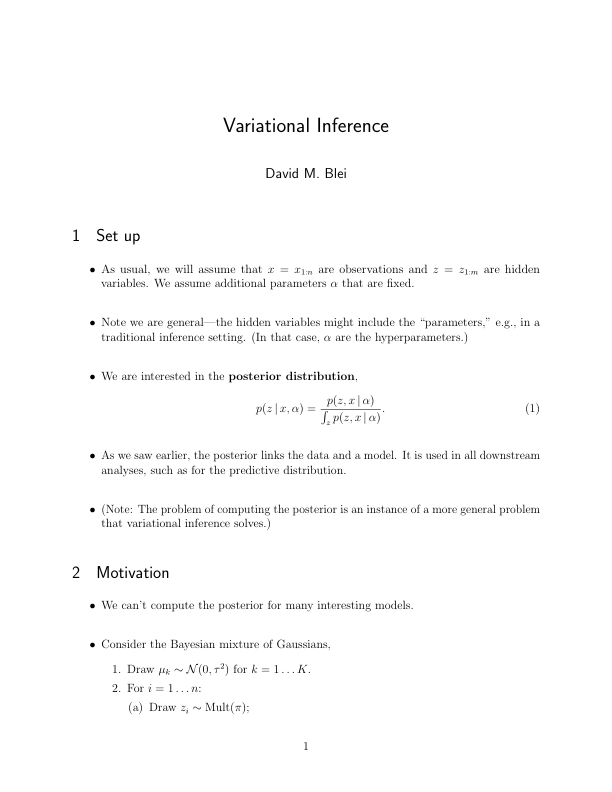

In [28]:
base64_to_pil(lrepo.get_obj(items[0]))

In [68]:
grepo.get_obj("prompts/")

['prompts/arch_extr.txt']

In [25]:
data

{'categories': {'proof_of_funds': {'validation': {'processor': 'LLMProcessor',
    'model': 'gemini-pro-vision'},
   'extraction': {'processor': 'PaliGemmaGradioProcessor',
    'api': '/compute',
    'model': 'big-vision/paligemma',
    'params': ['OCR', 'paligemma-3b-mix-224', 'greedy']}},
  'checks': {'validation': {'processor': 'DocumentValidationProcessor',
    'model': 'resnet18__clf.pt',
    'params': [{'img_size': [240, 320], 'target': 'clean'}],
    'classes': ['blanks', 'blurs', 'clean', 'dirty']},
   'extraction': {'processor': 'ApiProcessor',
    'api': 'http://localhost:8000/predict',
    'params': [{'instances': [{'data': '$image',
        'entity': 'payee',
        'guid': '$guid'}]}]}}}}

## testing api

In [61]:
from ocrorchestrator.main import app

In [62]:
from fastapi.testclient import TestClient
from ocrorchestrator.config.app_config import AppConfig

In [63]:
client = TestClient(app)

HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/b7bfa10f-f6da-4075-8e76-aee7867cc155 "HTTP/1.1 404 Not Found"
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/6f5eeb76-cb93-4387-9e64-38e949e4608b "HTTP/1.1 404 Not Found"


In [64]:
from base64 import b64encode
from pathlib import Path

b64 = b64encode(Path('../data/images/arch.png').open("rb").read())

HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/dd253886-bf2e-44af-a941-af7b3c5ac0cb "HTTP/1.1 404 Not Found"
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/b7bfa10f-f6da-4075-8e76-aee7867cc155 "HTTP/1.1 404 Not Found"
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/dd253886-bf2e-44af-a941-af7b3c5ac0cb "HTTP/1.1 404 Not Found"
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/6f5eeb76-cb93-4387-9e64-38e949e4608b "HTTP/1.1 404 Not Found"
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/6f5eeb76-cb93-4387-9e64-38e949e4608b "HTTP/1.1 404 Not Found"
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/b7bfa10f-f6da-4075-8e76-aee7867cc155 "HTTP/1.1 404 Not Found"
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/dd253886-bf2e-44af-a941-af7b3c5ac0cb "HTTP/1.1 404 Not Found"
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/6f5eeb76-cb93-4387-9e64-38e949e4608b "

In [65]:
req_body = {
    "image": b64.decode(),
    "category": "proof_of_funds",
    "task": "extraction",
    "guid": "dummyguid",
}

In [66]:
# from gradio_client import file
# result = clnt.predict(
# 		file('../data/images/arch.png'),	# filepath in 'Image' Image component
# 		"ocr \nReturn only the shapes as JSON",	# str in 'Prompt' Textbox component
#         "paligemma-3b-mix-224",
# 		"greedy",	# Literal['greedy', 'nucleus(0.1)', 'nucleus(0.3)', 'temperature(0.5)'] in 'Decoding' Dropdown component
# 		api_name="/compute"
# )



In [67]:
# print(result[0]['value'][0]['token'])

HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/dd253886-bf2e-44af-a941-af7b3c5ac0cb "HTTP/1.1 404 Not Found"
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/b7bfa10f-f6da-4075-8e76-aee7867cc155 "HTTP/1.1 404 Not Found"
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/6f5eeb76-cb93-4387-9e64-38e949e4608b "HTTP/1.1 404 Not Found"
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/dd253886-bf2e-44af-a941-af7b3c5ac0cb "HTTP/1.1 404 Not Found"
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/6f5eeb76-cb93-4387-9e64-38e949e4608b "HTTP/1.1 404 Not Found"


In [68]:
with TestClient(app) as client:
    response = client.post("/predict", json=req_body)
    print(response.json())

{"event": "Running LLM setup", "level": "info", "func_name": "setup", "lineno": 27, "timestamp": "2024-06-30T15:31:16.165814Z"}
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/dd253886-bf2e-44af-a941-af7b3c5ac0cb "HTTP/1.1 404 Not Found"
Loaded as API: https://big-vision-paligemma.hf.space ✔
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/6f5eeb76-cb93-4387-9e64-38e949e4608b "HTTP/1.1 404 Not Found"
HTTP Request: GET https://big-vision-paligemma.hf.space/config "HTTP/1.1 200 OK"
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/dd253886-bf2e-44af-a941-af7b3c5ac0cb "HTTP/1.1 404 Not Found"
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/6f5eeb76-cb93-4387-9e64-38e949e4608b "HTTP/1.1 404 Not Found"
HTTP Request: GET https://big-vision-paligemma.hf.space/info?serialize=False "HTTP/1.1 200 OK"
HTTP Request: GET https://big-vision-paligemma.hf.space/heartbeat/b7bfa10f-f6da-4075-8e76-aee7867cc155 "HTTP/1.1 404 Not Found"
H

In [29]:
test_()

{"event": "Running LLM setup", "level": "info", "func_name": "setup", "lineno": 27, "timestamp": "2024-06-30T13:53:19.639017Z"}
{"event": "Running LLM processor", "guid": "dummyguid", "api_name": "/predict", "trans_id": "75b0e676-876b-4223-bdf8-2cea5758d3d0", "client_host": "testclient", "method": "POST", "level": "info", "func_name": "process", "lineno": 31, "timestamp": "2024-06-30T13:53:19.642351Z"}
{"event": "OK", "guid": "dummyguid", "api_name": "/predict", "status_code": 200, "trans_id": "75b0e676-876b-4223-bdf8-2cea5758d3d0", "client_host": "testclient", "method": "POST", "level": "info", "func_name": "dispatch", "lineno": 48, "timestamp": "2024-06-30T13:53:19.643861Z"}
HTTP Request: POST http://testserver/predict "HTTP/1.1 200 OK"
{'status': 'OK', 'status_code': 200, 'message': {'name': 'John Doe', 'invoice_no': 'XYZ123'}}


In [64]:
from ocrorchestrator.main import LocalRepo, config_path, repo_args

In [73]:
config_path, repo_args

('configs/config_v1.yaml', ['/home/ajkdrag/workspace/projects/ocrorchestrator/data/my-bucket'])

In [74]:
repo = LocalRepo(*repo_args)

In [75]:
repo.get_yaml(config_path)

{'general': None, 'categories': {'proof_of_funds': {'validation': {'processor': 'llm', 'handler': 'gemini-pro-vision'}, 'extraction': {'processor': 'custom', 'handler': 'ProofOfFundsExtractor'}}, 'checks': {'extraction': {'processor': 'custom', 'handler': 'ProofOfFundsExtractor'}}}}

In [76]:
cfg = AppConfig(**repo.get_yaml(config_path))

In [77]:
cfg

AppConfig(general=GeneralConfig(prompts_dir='prompt_templates', models_dir='models'), categories={'proof_of_funds': OrderedDict([('validation', TaskConfig(processor='llm', handler='gemini-pro-vision', model=None, prompt_template=None, extra_kwargs={}, fields=None, classes=None)), ('extraction', TaskConfig(processor='custom', handler='ProofOfFundsExtractor', model=None, prompt_template=None, extra_kwargs={}, fields=None, classes=None))]), 'checks': OrderedDict([('extraction', TaskConfig(processor='custom', handler='ProofOfFundsExtractor', model=None, prompt_template=None, extra_kwargs={}, fields=None, classes=None))])})

In [78]:
cfg.general.prompts_dir

'prompt_templates'

In [79]:
cfg.general.models_dir

'models'

## testing doc processor

In [285]:
from ocrorchestrator.config.app_config import AppConfig
from ocrorchestrator.repos import LocalRepo
from ocrorchestrator.processors import DocumentValidationProcessor
from ocrorchestrator.datamodels.api_io import OCRRequest
from ocrorchestrator.utils.img import base64_to_pil

Reloading 'ocrorchestrator.utils.constants'.
Reloading 'ocrorchestrator.utils.ml'.


In [286]:
cfg_file = "../data/my-bucket/configs/config_v1.yaml"

In [287]:
repo = LocalRepo("../data/my-bucket")

In [288]:
cfg_dict = repo.get_yaml("configs/config_v1.yaml")

In [289]:
cfg = AppConfig(**cfg_dict)

In [290]:
task_cfg = cfg.categories["checks"]["validation"]

In [291]:
task_cfg

TaskConfig(processor='DocumentValidationProcessor', api=None, model='resnet18__clf.pt', prompt_template=None, params=[{'img_size': [240, 320], 'target': 'clean'}], fields=None, classes=['blanks', 'blurs', 'clean', 'dirty'], args=[], kwargs={'img_size': [240, 320], 'target': 'clean'})

In [292]:
from base64 import b64encode
from pathlib import Path

b64 = b64encode(Path('../data/images/arch.png').open("rb").read())

In [293]:
task_cfg.kwargs.get("target")

'clean'

In [294]:
req_body = {
    "image": b64.decode(),
    "category": "proof_of_funds",
    "task": "validation",
    "guid": "dummyguid",
}

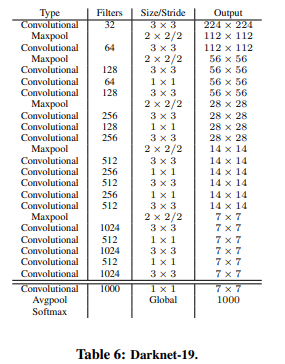

In [295]:
base64_to_pil(b64)

In [296]:
req = OCRRequest(**req_body)

In [297]:
proc = DocumentValidationProcessor(task_cfg, cfg.general, repo)

In [301]:
proc.setup()

{"event": "Initialized model resnet18 with 4 classes, on cpu", "level": "info", "func_name": "load_pretrained_classifier", "lineno": 31, "timestamp": "2024-07-01T11:23:00.111512Z"}
{"event": "Loading from checkpoint: ../data/my-bucket/models/resnet18__clf.pt", "level": "info", "func_name": "load_pretrained_classifier", "lineno": 34, "timestamp": "2024-07-01T11:23:00.112489Z"}


In [302]:
%%time
proc.process(req)

CPU times: user 122 ms, sys: 0 ns, total: 122 ms
Wall time: 28.4 ms


{'is_valid': False, 'reason': 'dirty', 'confidence': 0.9836628437042236}

In [9]:
from string import Template
lorem = "Lorem ipsum dolor sit amet {GIBBERISH}, consectetur adipiscing elit {DRIVEL}. Expectoque quid ad id, quod quaerebam, respondeas."
loremtpl = Template("Lorem ipsum dolor sit amet ${GIBBERISH}, consectetur adipiscing elit $DRIVEL. Expectoque quid ad id, quod quaerebam, respondeas.")
d = dict(GIBBERISH='FOOBAR', DRIVEL = 'RAXOOP')

In [10]:
loremtpl.safe_substitute(**d)

'Lorem ipsum dolor sit amet FOOBAR, consectetur adipiscing elit RAXOOP. Expectoque quid ad id, quod quaerebam, respondeas.'

## testing api processor

In [69]:
from ocrorchestrator.config.app_config import AppConfig
from ocrorchestrator.repos import LocalRepo
from ocrorchestrator.processors.api import ApiProcessor
from ocrorchestrator.datamodels.api_io import OCRRequest
from ocrorchestrator.utils.img import base64_to_pil

Reloading 'ocrorchestrator.config.app_config'.
Reloading 'ocrorchestrator.datamodels.api_io'.


In [70]:
cfg_file = "../data/my-bucket/configs/config_v1.yaml"

In [71]:
repo = LocalRepo("../data/my-bucket")

In [72]:
cfg_dict = repo.get_yaml("configs/config_v1.yaml")
cfg = AppConfig(**cfg_dict)

In [73]:
task_cfg = cfg.categories["checks"]["extraction"]
task_cfg

TaskConfig(processor='ApiProcessor', api='http://localhost:8000/predict', model=None, prompt_template=None, params=[{'instances': [{'data': '$image', 'entity': 'payee', 'guid': '$guid'}]}], fields=None, classes=None, args=[], kwargs={'instances': [{'data': '$image', 'entity': 'payee', 'guid': '$guid'}]})

In [74]:
task_cfg.kwargs

{'instances': [{'data': '$image', 'entity': 'payee', 'guid': '$guid'}]}

In [76]:
from ocrorchestrator.processors.api import InputFormatter

In [77]:
fmt = InputFormatter(task_cfg.kwargs)

In [96]:
from base64 import b64encode
from pathlib import Path

b64 = b64encode(Path('../data/images/arch.png').open("rb").read())

In [100]:
req_body = {
    "image": b64,
    "category": "proof_of_funds",
    "task": "validation",
    "guid": "dummyguid",
}

Reloading 'ocrorchestrator.datamodels.api_io'.


In [102]:
req = OCRRequest(**req_body)

In [106]:
formatted = fmt.format(req)

In [105]:
import json

str_dumped = json.dumps(
    {
        "instances": [{
            "data": req.image,
            "entity": "payee",
            "guid": req.guid,
        }]
    }
)

In [110]:
proc = ApiProcessor(task_cfg, cfg.general, repo)

In [112]:
proc._setup()

In [113]:
proc._process(req)

AppException: 601: API call error: HTTPConnectionPool(host='localhost', port=8000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5de0952940>: Failed to establish a new connection: [Errno 111] Connection refused'))